In [1]:
# !pip install folium
# !pip install geopy
# !pip install utm --user

In [2]:
import os
import utm
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
from geopy.distance import geodesic

import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

C:\Users\avitr\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
os.listdir()

['.ipynb_checkpoints',
 'doc1 (1).docx',
 'gps_copy-Copy1.ipynb',
 'gps_movement_map.html',
 'gps_v1.ipynb',
 'trackdata_c1.csv',
 'trackdata_c2.csv',
 'trackdata_cx.csv']

In [4]:
df1 = pd.read_csv('trackdata_c1.csv')
df2 = pd.read_csv('trackdata_c2.csv')
dfx = pd.read_csv('trackdata_cx.csv')

In [49]:
t = np.array([[1,2],[3,4]])
np.sqrt(np.sum(np.diff(t, axis=0) ** 2, axis=1))

array([2.82842712])

In [50]:
df1

,uid,row_number,lat,lon,ele,Target
0,5,1,40.428163,16.886404,295.26,1
1,5,2,40.500256,17.239304,30.42,1
2,5,3,40.520905,17.354200,56.86,1
3,5,4,40.534175,17.466975,165.00,1
4,5,5,40.514178,17.575920,143.85,1
...,...,...,...,...,...,...
319270,133546,13,52.273926,85.416458,-100.00,1
319271,133546,14,52.271350,85.415305,-100.00,1
319272,133546,15,52.289643,85.518263,-100.00,1
319273,133546,16,52.277541,85.415953,-100.00,1


In [5]:
def detect_fake_gps(trace, elevations):
    # Calculate distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(trace, axis=0) ** 2, axis=1))
    
    # Calculate the change in elevation between consecutive points
    elev_diff = np.abs(np.diff(elevations))
    
    # Calculate the mean and standard deviation of elevation differences
    mean_elev_diff = np.mean(elev_diff)
    std_elev_diff = np.std(elev_diff)
    
    # Define thresholds for distance deviation and elevation difference deviation
    distance_threshold = np.mean(distances) + 2 * np.std(distances)
    elev_diff_threshold = mean_elev_diff + 2 * std_elev_diff
    
    # Check if any distance or elevation difference exceeds the thresholds
    if np.any(distances > distance_threshold) or np.any(elev_diff > elev_diff_threshold):
        return 1  # fake GPS trace
    else:
        return 0  # real GPS trace

In [6]:
def get_features(train1):
    train1['longitude_diff'] = train1.groupby('uid').lon.diff().fillna(0)
    train1['latitude_diff'] = train1.groupby('uid').lat.diff().fillna(0)
    train1['elevation_diff'] = train1.groupby('uid').ele.diff().fillna(0)

    train1['UTMX'] = train1.progress_apply(lambda x:utm.from_latlon(x['lat'], x['lon'])[0],axis=1)
    train1['UTMY'] = train1.progress_apply(lambda x:utm.from_latlon(x['lat'], x['lon'])[1],axis=1)
    # Function to calculate distance between two points
    distance = lambda x_dif, y_dif: np.sqrt(x_dif**2 + y_dif**2)

    # Differencing UTM coordinates
    train1['UTMX_diff'] = train1.groupby('uid').UTMX.diff().fillna(0)
    train1['UTMY_diff'] = train1.groupby('uid').UTMY.diff().fillna(0)


    # Calculate step distance
    train1['distance'] = distance(train1.UTMX_diff, train1.UTMY_diff)

    # Interquartile and range function
    iqr = lambda x: np.percentile(x, 75) - np.percentile(x, 25)
    range = lambda x: np.max(x) - np.min(x)
    
    # Drop the last 1 column: label
    
    if 'Target' in train1 and 'row_number' in train1:
        df_grouped = train1.drop(['Target','row_number'],axis=1)
    else:
        df_grouped = train1.drop(['row_number'],axis=1)

    # Calculate summary statistics
    df_grouped = df_grouped.groupby('uid').aggregate([np.mean, np.min, np.max, np.std, iqr, range])

    # Reduce multi-index
    df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]

    # Replace column name <lambda_0> to IQR and <lambda_1> to range 
    col_groupby2 = df_grouped.columns
    col_groupby2 = [w.replace('<lambda_0>', 'IQR') for w in col_groupby2]
    col_groupby2 = [w.replace('<lambda_1>', 'range') for w in col_groupby2]

    # Update names of columns
    df_grouped.columns = col_groupby2
    return df_grouped

In [7]:
df1['Target'] = 1 # fake
df2['Target'] = 0 # real
train_data = pd.concat([df1,df2])
train_data.reset_index(drop=True,inplace=True)

In [8]:
train = get_features(train_data)

  0%|          | 0/3305525 [00:00<?, ?it/s]

  0%|          | 0/3305525 [00:00<?, ?it/s]

In [52]:
train

,uid,lat_mean,lat_min,lat_max,lat_std,lat_IQR,lat_range,lon_mean,lon_min,lon_max,...,UTMY_diff_std,UTMY_diff_IQR,UTMY_diff_range,distance_mean,distance_min,distance_max,distance_std,distance_IQR,distance_range,real_fake
0,1,55.418098,54.787308,55.822266,0.341705,0.603330,1.034958,56.117531,55.588547,56.950108,...,3703.913085,5055.969509,13950.451394,8628.712583,0.0,10031.928150,2297.540925,845.271554,10031.928150,1
1,2,44.054414,43.359176,44.672702,0.391334,0.532478,1.313526,77.473627,76.940681,78.044776,...,2984.768813,4723.909300,10266.845007,30926.978936,0.0,469683.669187,100559.798677,825.617826,469683.669187,1
2,3,45.698591,45.009685,46.363239,0.449408,0.745705,1.353554,78.673746,78.346336,78.949432,...,2689.921376,1418.478376,9817.167829,8909.361205,0.0,10488.479402,2469.948771,1038.118064,10488.479402,1
3,4,44.847123,43.360698,46.378494,0.906804,1.532298,3.017796,78.054398,76.941200,78.953773,...,2401.824914,2431.682134,10363.059794,19750.445879,0.0,469655.577194,69423.139875,1197.894029,469655.577194,1
4,5,40.497280,40.428163,40.534175,0.028543,0.033654,0.106012,17.409867,16.886404,17.932664,...,3058.316587,2782.401043,10658.457053,16381.064451,0.0,86006.438345,23139.584142,731.078895,86006.438345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118411,133567,53.763908,53.573748,53.946208,0.084851,0.136839,0.372460,84.996463,84.383895,85.513003,...,4261.108360,5598.791737,17089.043567,6739.702323,0.0,10371.158366,2810.428479,4005.219786,10371.158366,0
118412,133568,53.766510,53.573641,53.991068,0.098094,0.132100,0.417427,85.030571,84.627906,85.476268,...,5724.457138,7665.905229,52206.769133,6641.326519,0.0,31301.716038,3909.986422,3590.647741,31301.716038,1
118413,133569,53.397349,53.283201,53.531023,0.051601,0.059866,0.247822,82.600273,81.838820,83.742945,...,3262.999438,4356.351748,14773.475675,8567.920989,0.0,31374.994017,3259.657736,2584.665761,31374.994017,1
118414,133570,53.806992,53.529306,53.956058,0.100974,0.080121,0.426752,83.579390,83.072813,83.967285,...,4694.127682,6061.033668,19592.986791,5825.127852,0.0,11725.521004,3429.966911,6441.259631,11725.521004,0


In [9]:
real_fake = train_data.groupby('uid')[['lat','lon','ele']].progress_apply(lambda x: detect_fake_gps(x[['lat','lon']].values,x['ele']))

  0%|          | 0/118416 [00:00<?, ?it/s]

In [54]:
real_fake

,uid,real_fake
0,118,1
1,218,1
2,318,1
3,418,1
4,518,1
...,...,...
1778,118995,1
1779,118996,0
1780,118997,1
1781,118998,1


In [10]:
real_fake = real_fake.reset_index()
real_fake.columns = ['uid','real_fake']

In [11]:
real_fake

,uid,real_fake
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
118411,133567,0
118412,133568,1
118413,133569,1
118414,133570,0


In [12]:
train.head()

,lat_mean,lat_min,lat_max,lat_std,lat_IQR,lat_range,lon_mean,lon_min,lon_max,lon_std,...,UTMY_diff_max,UTMY_diff_std,UTMY_diff_IQR,UTMY_diff_range,distance_mean,distance_min,distance_max,distance_std,distance_IQR,distance_range
uid,,,,,,,,,,,,,,,,,,,,,
1,55.418098,54.787308,55.822266,0.341705,0.603330,1.034958,56.117531,55.588547,56.950108,0.409938,...,9790.486996,3703.913085,5055.969509,13950.451394,8628.712583,0.0,10031.928150,2297.540925,845.271554,10031.928150
2,44.054414,43.359176,44.672702,0.391334,0.532478,1.313526,77.473627,76.940681,78.044776,0.405839,...,10266.845007,2984.768813,4723.909300,10266.845007,30926.978936,0.0,469683.669187,100559.798677,825.617826,469683.669187
3,45.698591,45.009685,46.363239,0.449408,0.745705,1.353554,78.673746,78.346336,78.949432,0.175232,...,9817.167829,2689.921376,1418.478376,9817.167829,8909.361205,0.0,10488.479402,2469.948771,1038.118064,10488.479402
4,44.847123,43.360698,46.378494,0.906804,1.532298,3.017796,78.054398,76.941200,78.953773,0.661992,...,0.000000,2401.824914,2431.682134,10363.059794,19750.445879,0.0,469655.577194,69423.139875,1197.894029,469655.577194
5,40.497280,40.428163,40.534175,0.028543,0.033654,0.106012,17.409867,16.886404,17.932664,0.373163,...,8702.530107,3058.316587,2782.401043,10658.457053,16381.064451,0.0,86006.438345,23139.584142,731.078895,86006.438345


In [13]:
train = train.merge(real_fake,on='uid')

In [14]:
train = train.reset_index(drop=True)

In [15]:
target = train_data.groupby('uid')['Target'].mean().astype('int').reset_index()

In [16]:
df_train = target.merge(train,on='uid')

In [17]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [58]:
df_train.head()

,uid,Target,lat_mean,lat_min,lat_max,lat_std,lat_IQR,lat_range,lon_mean,lon_min,...,UTMY_diff_std,UTMY_diff_IQR,UTMY_diff_range,distance_mean,distance_min,distance_max,distance_std,distance_IQR,distance_range,real_fake
1,73446,1,12.558455,12.446241,12.621607,0.054775,0.077490,0.175366,122.566385,122.228363,...,7227.048119,6434.603061,26381.005903,22542.250217,0.0,77458.109432,23996.923807,10963.797079,77458.109432,1
2,36039,1,55.952123,55.887120,56.008390,0.047881,0.094925,0.121270,36.016325,35.852507,...,4985.482734,3209.306636,18365.420937,94911.156893,0.0,369781.537376,163367.250332,95294.950924,369781.537376,1
4,24740,0,44.908080,44.884694,44.955520,0.017143,0.025735,0.070826,27.784712,27.722906,...,3072.193619,4265.130386,11858.056400,5551.839134,0.0,10855.451805,3539.889451,5313.201601,10855.451805,1
5,48909,0,60.404189,59.880655,60.928778,0.352348,0.567007,1.048123,17.369217,17.091290,...,2896.309499,2473.866372,9804.375535,8010.437819,0.0,9964.618211,3077.211948,1564.486009,9964.618211,0
8,61287,0,41.770656,41.662608,41.906043,0.063809,0.062911,0.243435,8.919952,8.706468,...,3759.210902,5121.309904,13509.693309,5033.895960,0.0,9048.734947,2216.750305,1899.945643,9048.734947,1


In [61]:
df_train['Target'].value_counts(normalize=True)*100

Target
0    77.395973
1    22.604027
Name: proportion, dtype: float64

In [20]:
import seaborn as sns

<AxesSubplot:xlabel='Target', ylabel='count'>

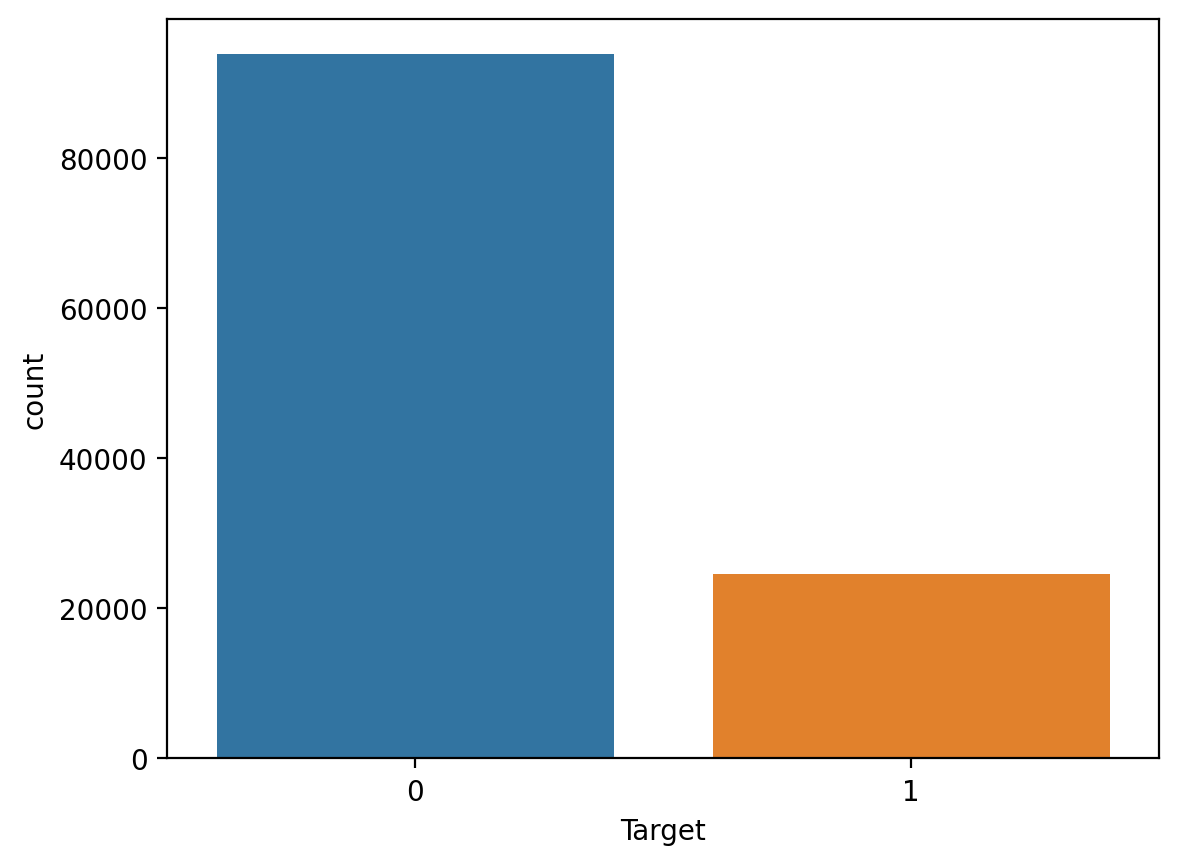

In [21]:
sns.countplot(data=df_train,x='Target')

In [22]:
df_train.shape

(118416, 69)

In [23]:
df_train.dropna(inplace=True)

In [24]:
X = df_train.drop(['uid','Target'],axis=1)
y = df_train['Target']

In [25]:
# from imblearn.over_sampling import SMOTE
# X, y = SMOTE().fit_resample(X, y)

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ML Models

In [27]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import model_selection
from xgboost.sklearn import XGBClassifier
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score

MLA = [
    ensemble.RandomForestClassifier(n_jobs=-1, random_state = 0),
    XGBClassifier(n_jobs=-1),
]

MLA_columns = ['MLA_names', 'MLA_parameters', 'MLA_Train_Accuracy_Mean','MLA_Test_Accuracy_Mean']

def apply_models(X,y):
    MLA_compare = pd.DataFrame(columns = MLA_columns)

#     MLA_Predict = y_test.copy()
    row_index = 0
    for alg in tqdm(MLA):
        try:
            MLA_name = alg.__class__.__name__
            MLA_compare.loc[row_index, 'MLA_names'] = MLA_name
            MLA_compare.loc[row_index, 'MLA_parameters'] = str(alg.get_params())
            cv_results = model_selection.cross_validate(alg, X, y,scoring='f1', cv=5, 
                                                        return_train_score = True,n_jobs=-1)
            MLA_compare.loc[row_index, 'MLA_Train_Accuracy_Mean'] = cv_results["train_score"].mean()
            MLA_compare.loc[row_index, 'MLA_Test_Accuracy_Mean'] = cv_results['test_score'].mean()
            row_index += 1
            print(".", end="")
        except:
            print(type(alg).__name__)
    MLA_compare.sort_values(by = 'MLA_Test_Accuracy_Mean', ascending = False, inplace = True)
    return MLA_compare

In [28]:
apply_models(X,y)

  0%|          | 0/2 [00:00<?, ?it/s]

..

,MLA_names,MLA_parameters,MLA_Train_Accuracy_Mean,MLA_Test_Accuracy_Mean
1,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.927756,0.82981
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.996676,0.809739


# Predict

In [29]:
dfx_cleaned = get_features(dfx)

  0%|          | 0/50980 [00:00<?, ?it/s]

  0%|          | 0/50980 [00:00<?, ?it/s]

In [30]:
dfx_cleaned = dfx_cleaned.reset_index()

In [31]:
dfx_cleaned.dropna(inplace=True)

In [32]:
real_fake = dfx.groupby('uid')[['lat','lon','ele']].progress_apply(lambda x: detect_fake_gps(x[['lat','lon']].values,x['ele']))

  0%|          | 0/1783 [00:00<?, ?it/s]

In [33]:
real_fake = real_fake.reset_index()
real_fake.columns = ['uid','real_fake']
dfx_cleaned = dfx_cleaned.merge(real_fake,on='uid')

In [62]:
dfx_cleaned

,uid,lat_mean,lat_min,lat_max,lat_std,lat_IQR,lat_range,lon_mean,lon_min,lon_max,...,UTMY_diff_std,UTMY_diff_IQR,UTMY_diff_range,distance_mean,distance_min,distance_max,distance_std,distance_IQR,distance_range,real_fake
0,118,49.185954,48.568535,49.784248,0.391094,0.629640,1.215713,39.091472,38.917839,39.316261,...,36111.688918,3426.006084,198974.990570,18803.347115,0.0,128596.503091,31570.196959,1206.786993,128596.503091,1
1,218,27.296405,26.835702,28.133820,0.443135,0.733151,1.298118,76.370914,75.799263,76.642002,...,52627.020203,10101.086352,269113.814352,32225.744891,0.0,152229.839184,49438.718842,353.630776,152229.839184,1
2,318,-32.181043,-33.172162,-31.394941,0.536964,0.735955,1.777221,-64.669008,-65.072546,-64.177088,...,44478.050218,7746.940118,300707.464911,23853.844285,0.0,209031.027748,41513.720221,2958.203810,209031.027748,1
3,418,-35.207118,-35.720821,-34.800841,0.320336,0.554178,0.919980,147.910866,147.316145,148.641685,...,13699.853917,6996.741439,68334.987980,15066.587155,0.0,93617.334754,19532.399512,505.589165,93617.334754,1
4,518,61.185883,60.728218,61.487236,0.209681,0.300565,0.759018,74.267951,72.610206,76.586288,...,14823.540013,9560.566159,92695.627758,35183.840519,0.0,199455.545333,61121.234842,826.626176,199455.545333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,91894,46.506330,46.408417,46.651511,0.081932,0.114879,0.243094,16.148951,16.077483,16.212430,...,7234.335534,8746.133694,22903.429310,6853.154316,0.0,15415.198878,3849.951259,2616.970120,15415.198878,1
902,91895,46.470358,46.399770,46.520448,0.042540,0.088169,0.120678,16.169156,16.073985,16.256182,...,4846.888658,2929.314603,18802.883417,5586.382706,0.0,13810.185833,4125.299673,5868.638161,13810.185833,1
903,91896,46.461638,46.399963,46.530726,0.043884,0.079849,0.130763,16.177188,16.057248,16.269679,...,5983.105054,9702.321600,18022.816993,7040.459851,0.0,14813.757724,3390.521171,3087.460264,14813.757724,1
904,91897,55.422460,55.355853,55.483858,0.041933,0.050173,0.128005,37.302566,37.010015,37.548154,...,5049.859789,4792.138630,17344.311754,11961.150505,0.0,34124.156011,9329.619226,7320.934723,34124.156011,1


In [34]:
X_test = dfx_cleaned.drop(['uid'],axis=1)

X_test = scaler.transform(X_test)

In [35]:
alg = ensemble.RandomForestClassifier(n_jobs=-1, random_state = 0)
alg.fit(X, y)
y_pred = alg.predict(X_test)

In [36]:
CX_pred = pd.DataFrame({'uid':dfx_cleaned['uid'].tolist(),'Pred':y_pred})
CX_pred

,uid,Pred
0,118,0
1,218,0
2,318,0
3,418,0
4,518,0
...,...,...
901,91894,1
902,91895,1
903,91896,1
904,91897,1


# Fake

In [37]:
import folium
# pip install folium
def draw(data):
    data.reset_index(drop=True,inplace=True)
    
    map_center = [data["lat"][0], data["lon"][0]]
    mymap = folium.Map(location=map_center, zoom_start=10)
    
    # Add start marker
    folium.Marker(location=[data["lat"].values[0], data["lon"].values[0]], icon=folium.Icon(color="green"), popup="Start").add_to(mymap)

    # Add end marker
    folium.Marker(location=[data["lat"].values[-1], data["lon"].values[-1]], icon=folium.Icon(color="red"), popup="End").add_to(mymap)

    
    for lat,long in zip(data['lat'],data['lon']):
        folium.CircleMarker([lat,long],radius=5, color='red',fill=True).add_to(mymap)
    display(mymap)

In [38]:
temp = df1[df1['uid']==7]
temp

draw(temp)

In [39]:
temp = df1[df1['uid']==5]
temp

draw(temp)

# Real

In [40]:
set(df2['uid'])

{1,
 2,
 3,
 4,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 24,
 25,
 26,
 27,
 28,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 44,
 45,
 49,
 50,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 74,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 95,
 97,
 99,
 100,
 101,
 103,
 104,
 105,
 106,
 107,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 120,
 121,
 122,
 124,
 125,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 143,
 144,
 147,
 148,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 161,
 162,
 166,
 167,
 169,
 171,
 172,
 173,
 174,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 193,
 194,
 196,
 197,
 199,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 212,
 213,
 214,
 215,
 219,
 220,
 221,
 222,
 223,
 224,
 226,
 227,
 228,
 229,
 230,
 235,
 236,
 237,
 238,
 243,
 244,
 245,
 246,
 247,
 248,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 2

In [41]:
temp = df2[df2['uid']==13]
temp

draw(temp)

In [42]:
temp = df2[df2['uid']==2]
temp

draw(temp)

# Prediction

In [43]:
CX_pred

,uid,Pred
0,118,0
1,218,0
2,318,0
3,418,0
4,518,0
...,...,...
901,91894,1
902,91895,1
903,91896,1
904,91897,1


In [48]:
temp = dfx[dfx['uid']==91894] # fake
temp

draw(temp)

In [63]:
temp = dfx[dfx['uid']==118] # fake
temp

draw(temp)

# Q2
using folium we can plot the interacgtive view so as to check if its having issue or not

# Q3
- add distance between actual start and end of gps location
- Also, the beginning and end of the gps location as per scale on map

# Q4

- yes this data can be used for traffic analysis. first we need to find out the read gps traces and then overlap of their traces

# Q5

No, we need to perform feature engineering to create few features having enough potential to classified as issues/Not

# Q6

in the above machine learning models, we have performed prediciton of CX dataset

# Q7

- add distance between actual start and end of gps location
- add average speed
- Also, the beginning and end of the gps location as per scale on map

# Future scope

- need to create few more complex features
- need to test with deep learning models.
- also need to balanace the dataset as we have lot more data for Real but less data for Fake

In [45]:
df_train['Target'].value_counts(normalize=True)*100

Target
0    77.395973
1    22.604027
Name: proportion, dtype: float64

<AxesSubplot:xlabel='Target', ylabel='count'>

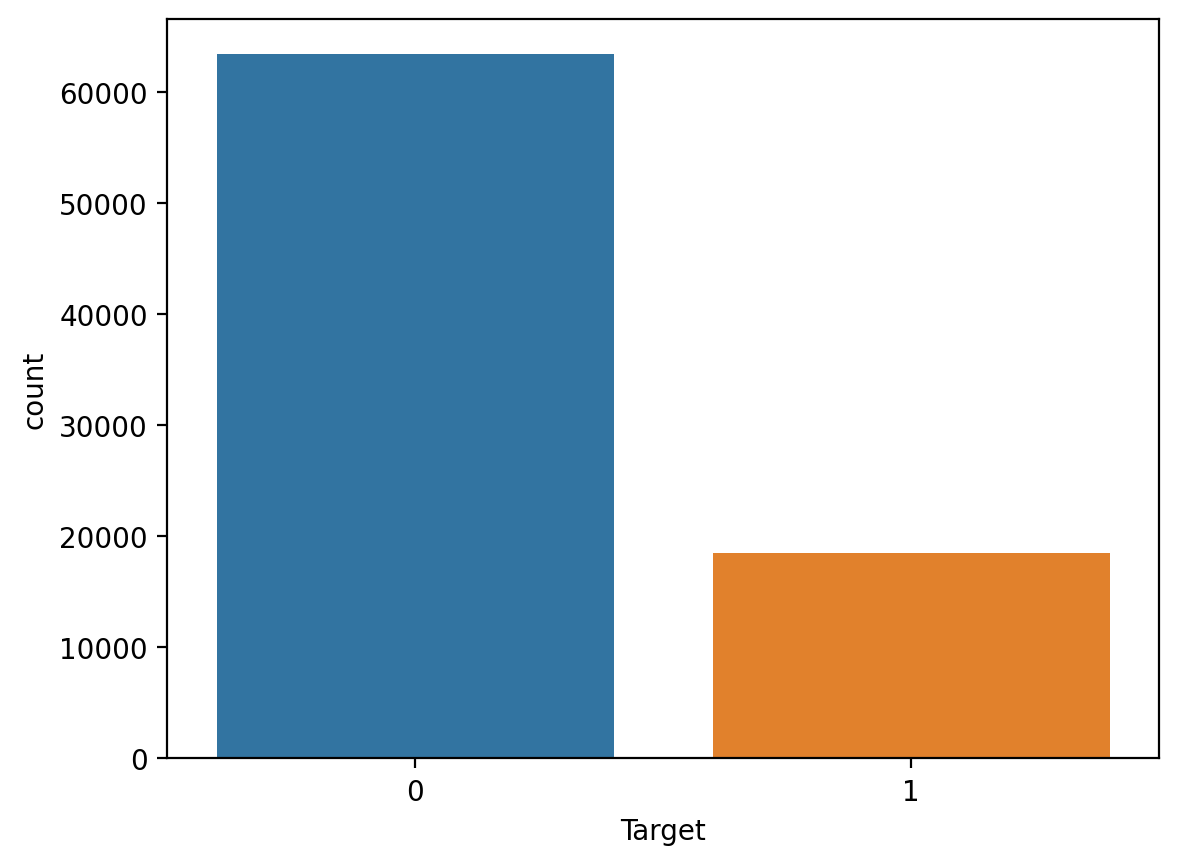

In [46]:
sns.countplot(data=df_train,x='Target')